In [7]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from utils import load_series_dfs
import pickle
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from scipy.signal import periodogram
import logging
from sklearn.preprocessing import StandardScaler
import itertools
import numpy as np

In [8]:
series_dfs = load_series_dfs(data_dir=r"C:\Users\johan\Documents\FH_Master\data", filename="final_learning_dfs.pkl")
series_dfs['FL_00024702.PLAN.MengeHH'].columns

Index(['consumption', 'hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
       'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10',
       'w_tb20', 'CEGH_WAP', 'THE_WAP'],
      dtype='object')

In [9]:
df = series_dfs['FL_00024702.PLAN.MengeHH']

df.index = pd.to_datetime(df.index)
df = df.sort_index()
# 1) Dubletten raushauen (oder vorher groupby mean)
df = df[~df.index.duplicated(keep='first')]

# 2) Sortieren
df = df.sort_index()

# 3) Resample und interpolieren – Index wird gesetzt und freq='h' hinterlegt
df = df.resample('h').interpolate()

# 4) (Optional) nochmal explizit asfreq, freq ist aber schon da
df = df.asfreq('h')

print(df.index.freq)

# Optional: Regressoren standardisieren
features_full = ['hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
            'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm',
            'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']



<Hour>


In [10]:
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train/Test Split
train = df.loc[:'2017-12-31']
test  = df.loc['2018-01-01':]
n_test = len(test)
y_true = test['consumption']

# Funktion für Fehler
def calc_metrics(y, y_hat):
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    mae  = mean_absolute_error(y, y_hat)
    return rmse, mae

features_full = ['hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
            'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm',
            'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']

# Platz für Ergebnisse
results = []

# SARIMAX (mit Exogenen)
t0 = time.perf_counter()
mod = SARIMAX(train['consumption'],
              exog=train[features_full],
              order=(1,0,2), seasonal_order=(1,0,1,24),
              enforce_stationarity=True, enforce_invertibility=True)
res = mod.fit(disp=False, method='powell', maxiter=300)
t1 = time.perf_counter()
pred_start = time.perf_counter()
yhat = res.get_forecast(steps=n_test, exog=test[features_full]).predicted_mean
t2 = time.perf_counter()

rmse, mae = calc_metrics(y_true, yhat)

results.append({
    'Model': 'SARIMAX',
    'RMSE': rmse, 'MAE': mae,
    'Train Time (s)': t1-t0,
    'Forecast Time (s)': t2-t1
})


KeyboardInterrupt: 

In [12]:
import time
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

df = series_dfs['FL_00024702.PLAN.MengeHH'].copy()
df.index = pd.to_datetime(df.index)
df = df[~df.index.duplicated(keep='first')].sort_index()
df = df.resample('h').interpolate().asfreq('h')

# Train/Test Split
train = df.loc[:'2017-12-31']
test  = df.loc['2018-01-01':]
n_test = len(test)
y_true = test['consumption']

def calc_metrics(y, y_hat):
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    mae  = mean_absolute_error(y, y_hat)
    return rmse, mae

# Start-Featureliste
features_full = [
    'hour','weekday','month','is_weekend','w_tl','w_rf','w_ff','w_ffx',
    'w_cglo','w_so_h','w_rr','w_rrm','w_tb10','w_tb20','CEGH_WAP','THE_WAP'
]

results = []

def fit_forecast_eval(feats):
    """Fit SARIMAX mit exog=feats, return (rmse, mae, train_time, fc_time, yhat) oder None bei Fehler."""
    X_train = train[feats] if feats else None
    X_test  = test[feats]  if feats else None

    t0 = time.perf_counter()
    try:
        print(feats)
        mod = SARIMAX(
            train['consumption'],
            exog=X_train,
            order=(1,0,2), seasonal_order=(1,0,1,24),
            enforce_stationarity=True, enforce_invertibility=True
        )
        res = mod.fit(disp=False, method='powell', maxiter=300)
    except Exception as e:
        return None
    t1 = time.perf_counter()

    try:
        yhat = res.get_forecast(steps=n_test, exog=X_test).predicted_mean
    except Exception:
        return None
    t2 = time.perf_counter()

    rmse, mae = calc_metrics(y_true, yhat)
    return rmse, mae, (t1 - t0), (t2 - t1), yhat

# 1) Baseline mit allen Features
current_features = features_full.copy()
baseline = fit_forecast_eval(current_features)
if baseline is None:
    raise RuntimeError("Baseline-Fit mit allen Features fehlgeschlagen.")
rmse, mae, tr_t, fc_t, _ = baseline
results.append({
    'Model': f"SARIMAX | k={len(current_features)} | Start (alle Features)",
    'Included Features': current_features.copy(),
    'Dropped in this step': None,
    'RMSE': rmse, 'MAE': mae,
    'Train Time (s)': tr_t, 'Forecast Time (s)': fc_t
})

# 2) Greedy Backward Elimination: in jedem Schritt genau 1 Feature droppen
while len(current_features) > 0:
    print(current_features)
    step_candidates = []
    for f in current_features:
        trial_feats = [x for x in current_features if x != f]
        eval_res = fit_forecast_eval(trial_feats)
        if eval_res is None:
            continue
        rmse_t, mae_t, tr_t, fc_t, _ = eval_res
        step_candidates.append({
            'drop_feature': f,
            'trial_feats': trial_feats,
            'RMSE': rmse_t,
            'MAE': mae_t,
            'Train Time (s)': tr_t,
            'Forecast Time (s)': fc_t
        })

    if not step_candidates:
        # keine erfolgreichen Fits mehr => Abbruch
        break

    # bestes Ergebnis nach RMSE auswählen (bei Gleichstand nach MAE)
    step_candidates.sort(key=lambda d: (d['RMSE'], d['MAE']))
    best = step_candidates[0]

    # Ergebnis protokollieren
    results.append({
        'Model': f"SARIMAX | k={len(best['trial_feats'])} | drop: {best['drop_feature']}",
        'Included Features': best['trial_feats'].copy(),
        'Dropped in this step': best['drop_feature'],
        'RMSE': best['RMSE'], 'MAE': best['MAE'],
        'Train Time (s)': best['Train Time (s)'],
        'Forecast Time (s)': best['Forecast Time (s)']
    })

    # Features aktualisieren (ein Feature weniger)
    current_features = best['trial_feats']


results_df = pd.DataFrame(results)
display(results_df)


['hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf', 'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']
['hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf', 'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']
['weekday', 'month', 'is_weekend', 'w_tl', 'w_rf', 'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']
['hour', 'month', 'is_weekend', 'w_tl', 'w_rf', 'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']
['hour', 'weekday', 'is_weekend', 'w_tl', 'w_rf', 'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']
['hour', 'weekday', 'month', 'w_tl', 'w_rf', 'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']
['hour', 'weekday', 'month', 'is_weekend', 'w_rf', 'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', '

,Model,Included Features,Dropped in this step,RMSE,MAE,Train Time (s),Forecast Time (s)
0,SARIMAX | k=16 | Start (alle Features),"[hour, weekday, month, is_weekend, w_tl, w_rf,...",None,6.566899,5.226988,451.113628,0.238235
1,SARIMAX | k=15 | drop: month,"[hour, weekday, is_weekend, w_tl, w_rf, w_ff, ...",month,6.467763,5.174850,419.311668,0.215744
2,SARIMAX | k=14 | drop: w_so_h,"[hour, weekday, is_weekend, w_tl, w_rf, w_ff, ...",w_so_h,6.448788,5.160024,553.240734,0.382631
3,SARIMAX | k=13 | drop: w_cglo,"[hour, weekday, is_weekend, w_tl, w_rf, w_ff, ...",w_cglo,6.429360,5.141524,727.640007,0.566107
4,SARIMAX | k=12 | drop: w_ffx,"[hour, weekday, is_weekend, w_tl, w_rf, w_ff, ...",w_ffx,6.365116,5.091095,351.557694,0.249103
5,SARIMAX | k=11 | drop: is_weekend,"[hour, weekday, w_tl, w_rf, w_ff, w_rr, w_rrm,...",is_weekend,6.365689,5.090716,341.143380,0.284294
6,SARIMAX | k=10 | drop: w_rf,"[hour, weekday, w_tl, w_ff, w_rr, w_rrm, w_tb1...",w_rf,6.342824,5.082941,351.862645,0.234021
7,SARIMAX | k=9 | drop: w_rrm,"[hour, weekday, w_tl, w_ff, w_rr, w_tb10, w_tb...",w_rrm,6.328288,5.074058,327.982167,0.269406
8,SARIMAX | k=8 | drop: w_rr,"[hour, weekday, w_tl, w_ff, w_tb10, w_tb20, CE...",w_rr,6.337519,5.080702,313.005122,0.240600
9,SARIMAX | k=7 | drop: weekday,"[hour, w_tl, w_ff, w_tb10, w_tb20, CEGH_WAP, T...",weekday,6.359246,5.094482,295.467360,0.269738


In [15]:
results_df.to_csv(r'../data_public/results_eval_simplifivation_sarimax.csv')

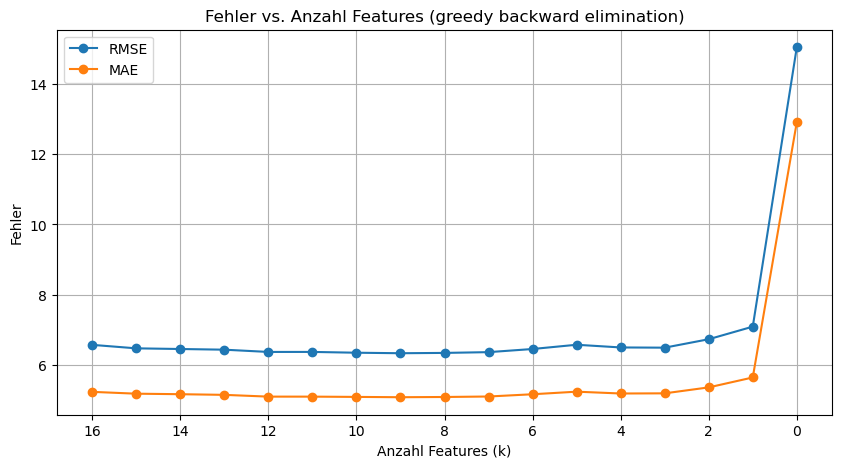

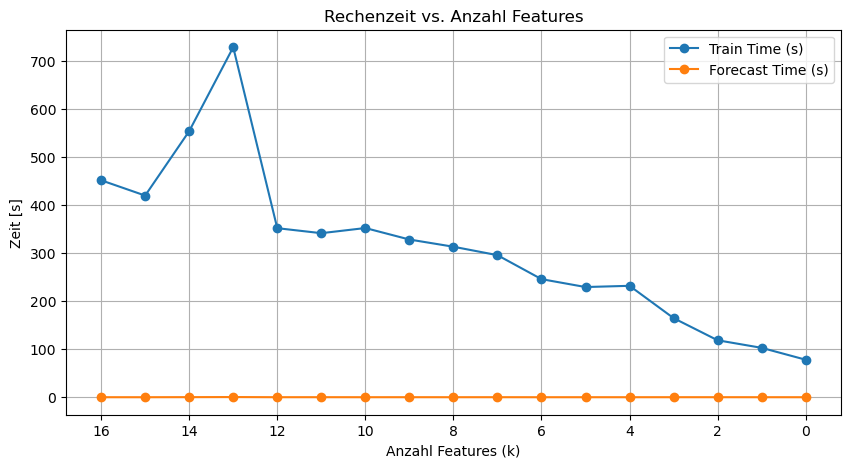

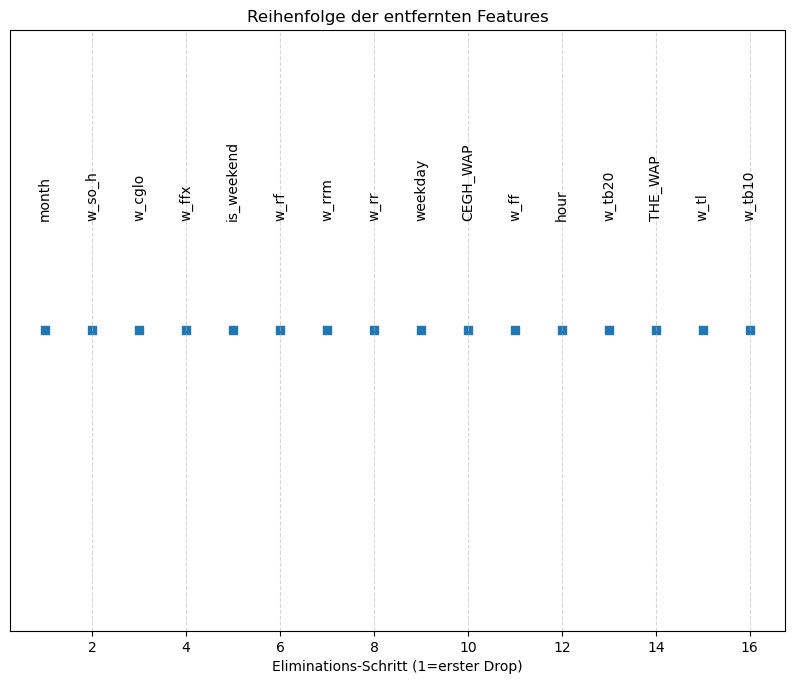

In [16]:
df = pd.read_csv("../data_public/results_eval_simplifivation_sarimax.csv")

# k extrahieren
df["k"] = df["Model"].str.extract(r'k=(\d+)').astype(int)

# In aufsteigender Iterationsreihenfolge lassen (so wie im CSV)
df = df.reset_index(drop=True)

# 1) RMSE & MAE vs. k
plt.figure(figsize=(10, 5))
plt.plot(df["k"], df["RMSE"], marker="o", label="RMSE")
plt.plot(df["k"], df["MAE"], marker="o", label="MAE")
plt.gca().invert_xaxis()  # weniger Features -> rechts, visuell intuitiv
plt.xlabel("Anzahl Features (k)")
plt.ylabel("Fehler")
plt.title("Fehler vs. Anzahl Features (greedy backward elimination)")
plt.legend()
plt.grid(True)
plt.show()

# 2) Rechenzeit vs. k (Train & Forecast)
plt.figure(figsize=(10, 5))
plt.plot(df["k"], df["Train Time (s)"], marker="o", label="Train Time (s)")
plt.plot(df["k"], df["Forecast Time (s)"], marker="o", label="Forecast Time (s)")
plt.gca().invert_xaxis()
plt.xlabel("Anzahl Features (k)")
plt.ylabel("Zeit [s]")
plt.title("Rechenzeit vs. Anzahl Features")
plt.legend()
plt.grid(True)
plt.show()

# 3) Timeline der gedroppten Features
# Für die Baseline ist 'Dropped in this step' NaN; wir blenden sie für die Timeline aus.
df_drop = df.dropna(subset=["Dropped in this step"]).copy()
df_drop["step"] = range(1, len(df_drop) + 1)

plt.figure(figsize=(10, 3 + 0.3*len(df_drop)))
plt.scatter(df_drop["step"], [1]*len(df_drop), marker="s")
for _, row in df_drop.iterrows():
    plt.text(row["step"], 1.02, row["Dropped in this step"], rotation=90, va="bottom", ha="center")
plt.yticks([])
plt.xlabel("Eliminations-Schritt (1=erster Drop)")
plt.title("Reihenfolge der entfernten Features")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()

Pareto-Front (nicht-dominierte Modelle):


,Model,k,RMSE,Train Time (s),Dropped in this step
7,SARIMAX | k=9 | drop: w_rrm,9,6.328288,327.982167,w_rrm
8,SARIMAX | k=8 | drop: w_rr,8,6.337519,313.005122,w_rr
9,SARIMAX | k=7 | drop: weekday,7,6.359246,295.467360,weekday
10,SARIMAX | k=6 | drop: CEGH_WAP,6,6.448862,245.633828,CEGH_WAP
13,SARIMAX | k=3 | drop: w_tb20,3,6.487009,164.612690,w_tb20
14,SARIMAX | k=2 | drop: THE_WAP,2,6.727591,118.585005,THE_WAP
15,SARIMAX | k=1 | drop: w_tl,1,7.086395,102.848665,w_tl
16,SARIMAX | k=0 | drop: w_tb10,0,15.053245,78.177295,w_tb10


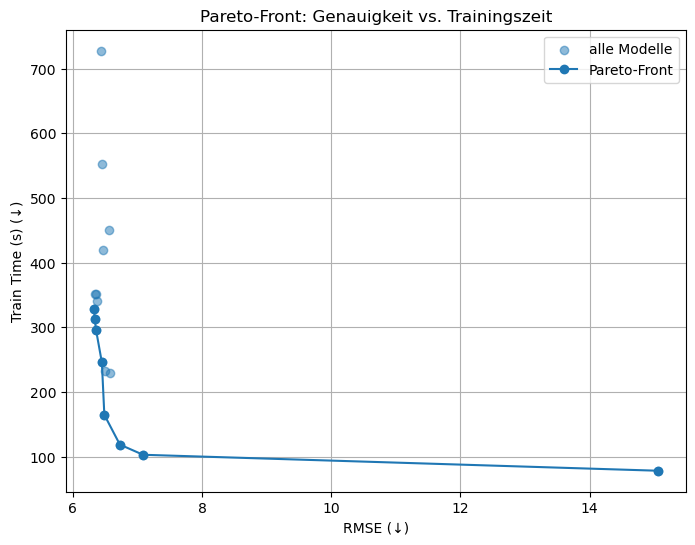

RMSE-Toleranz-Sweetspot (<= 1% über Minimum):
  k=7, RMSE=6.3592, Train Time=295.5s
  Modell: SARIMAX | k=7 | drop: weekday
  Features: ['hour', 'w_tl', 'w_ff', 'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']

Bester kombinierter Score (70% RMSE, 30% Zeit):
  k=2, RMSE=6.7276, Train Time=118.6s, Score=0.051
  Modell: SARIMAX | k=2 | drop: THE_WAP


In [17]:
df_eval = df.copy()
df_eval["k"] = df_eval["Model"].str.extract(r'k=(\d+)').astype(int)
df_eval["RMSE"] = df_eval["RMSE"].astype(float)
df_eval["Train Time (s)"] = df_eval["Train Time (s)"].astype(float)

# ========= 1) Pareto-Front (RMSE minimieren, Train Time minimieren) =========
def pareto_front(df_in, cols=("RMSE", "Train Time (s)")):
    A, B = cols
    pts = df_in[[A, B]].values
    is_dominated = np.zeros(len(pts), dtype=bool)
    for i in range(len(pts)):
        if is_dominated[i]:
            continue
        # Punkt i wird dominiert, wenn es einen j gibt: RMSE_j <= RMSE_i und TIME_j <= TIME_i,
        # und mindestens eine der beiden Ungleichungen ist strikt.
        dominates = (df_in[A].values <= pts[i, 0]) & (df_in[B].values <= pts[i, 1]) \
                    & ((df_in[A].values < pts[i, 0]) | (df_in[B].values < pts[i, 1]))
        if dominates.any():
            is_dominated[i] = True
    front_df = df_in.loc[~is_dominated].copy()
    # zur schöneren Kurve nach RMSE sortieren
    front_df = front_df.sort_values(A)
    return front_df

front = pareto_front(df_eval)

print("Pareto-Front (nicht-dominierte Modelle):")
display(front[["Model","k","RMSE","Train Time (s)","Dropped in this step"]])

# Visualisierung: RMSE vs Train Time mit Pareto-Front
plt.figure(figsize=(8,6))
plt.scatter(df_eval["RMSE"], df_eval["Train Time (s)"], alpha=0.5, label="alle Modelle")
plt.plot(front["RMSE"], front["Train Time (s)"], marker="o", label="Pareto-Front")
plt.xlabel("RMSE (↓)")
plt.ylabel("Train Time (s) (↓)")
plt.title("Pareto-Front: Genauigkeit vs. Trainingszeit")
plt.grid(True)
plt.legend()
plt.show()

# ========= 2) RMSE-Toleranz + minimale Zeit =========
alpha = 0.01  # 1 % Toleranz ggü. minimalem RMSE
rmse_min = df_eval["RMSE"].min()
thresh = rmse_min * (1 + alpha)

candidates = df_eval[df_eval["RMSE"] <= thresh].copy()
best_speed = candidates.sort_values("Train Time (s)", ascending=True).iloc[0]

print(f"RMSE-Toleranz-Sweetspot (<= {alpha*100:.0f}% über Minimum):")
print(f"  k={int(best_speed['k'])}, RMSE={best_speed['RMSE']:.4f}, "
      f"Train Time={best_speed['Train Time (s)']:.1f}s")
print("  Modell:", best_speed["Model"])
print("  Features:", best_speed["Included Features"])

# Optional: kombinierter Score (normiert) für flexible Gewichtung
def combined_score(df_in, w_rmse=0.7, w_time=0.3):
    # Min-Max-Normierung (kleiner ist besser)
    rmse_n = (df_in["RMSE"] - df_in["RMSE"].min()) / (df_in["RMSE"].max() - df_in["RMSE"].min())
    time_n = (df_in["Train Time (s)"] - df_in["Train Time (s)"].min()) / (df_in["Train Time (s)"].max() - df_in["Train Time (s)"].min())
    return w_rmse * rmse_n + w_time * time_n

df_eval["score_70_30"] = combined_score(df_eval, 0.7, 0.3)
best_score = df_eval.sort_values("score_70_30").iloc[0]
print("\nBester kombinierter Score (70% RMSE, 30% Zeit):")
print(f"  k={int(best_score['k'])}, RMSE={best_score['RMSE']:.4f}, "
      f"Train Time={best_score['Train Time (s)']:.1f}s, Score={best_score['score_70_30']:.3f}")
print("  Modell:", best_score["Model"])

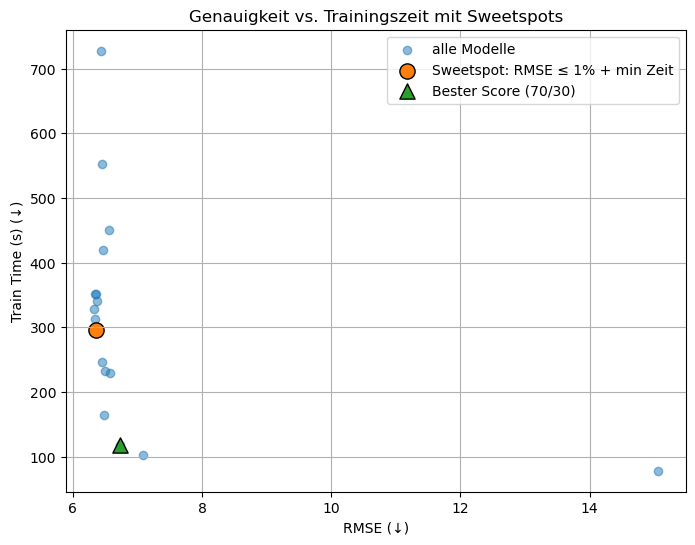

In [18]:
min_rmse = df["RMSE"].min()
thresh = min_rmse * 1.01

# Kandidat für RMSE-Toleranz-Sweetspot (<= 1%)
candidates = df[df["RMSE"] <= thresh].copy()
best_speed = candidates.sort_values("Train Time (s)", ascending=True).iloc[0]

# Kombinierter Score (70/30)
def combined_score(df_in, w_rmse=0.7, w_time=0.3):
    rmse_n = (df_in["RMSE"] - df_in["RMSE"].min()) / (df_in["RMSE"].max() - df_in["RMSE"].min())
    time_n = (df_in["Train Time (s)"] - df_in["Train Time (s)"].min()) / (df_in["Train Time (s)"].max() - df_in["Train Time (s)"].min())
    return w_rmse * rmse_n + w_time * time_n

df["score_70_30"] = combined_score(df, 0.7, 0.3)
best_score = df.sort_values("score_70_30").iloc[0]

# Scatter aller Modelle
plt.figure(figsize=(8,6))
plt.scatter(df["RMSE"], df["Train Time (s)"], alpha=0.5, label="alle Modelle")

# Markiere RMSE-Toleranz-Sweetspot
plt.scatter(best_speed["RMSE"], best_speed["Train Time (s)"], s=120, marker="o", edgecolor="black", label="Sweetspot: RMSE ≤ 1% + min Zeit")

# Markiere kombinierten Score
plt.scatter(best_score["RMSE"], best_score["Train Time (s)"], s=120, marker="^", edgecolor="black", label="Bester Score (70/30)")

plt.xlabel("RMSE (↓)")
plt.ylabel("Train Time (s) (↓)")
plt.title("Genauigkeit vs. Trainingszeit mit Sweetspots")
plt.grid(True)
plt.legend()
plt.show()

In [19]:
import time, warnings, numpy as np, pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

# ===== Parameter zum Tuning =====
OPT_METHOD   = "powell"     # schneller als 'powell' in vielen Fällen
MAXITER      = 100         # weniger Iterationen
PER_ITER_LIM = 6           # pro Runde nur diese Anzahl Drop-Kandidaten testen
K_MIN        = 6           # nicht unter diese Feature-Anzahl gehen (Early Stop)
RMSE_TOL     = 0.003       # abbrechen, wenn Verbesserung < 0.3% relativ zum Bestwert

def calc_metrics(y, y_hat):
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    mae  = mean_absolute_error(y, y_hat)
    return rmse, mae

def greedy_be_sarimax(df, features_full, end_train="2017-12-31", start_test="2018-01-01"):
    # --- Split & Vorbereitung ---
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df[~df.index.duplicated(keep="first")].sort_index().resample("h").interpolate().asfreq("h")
    train, test = df.loc[:end_train], df.loc[start_test:]
    y_true = test["consumption"]
    n_test = len(test)

    # Heuristik: Korrelationen (absolut) im Train zur Vorauswahl schwacher Features
    corr_abs = {}
    for f in features_full:
        try:
            corr_abs[f] = abs(np.corrcoef(train[f].values, train["consumption"].values)[0,1])
        except Exception:
            corr_abs[f] = 0.0

    # --- Cache: Feature-Tuple -> Ergebnis ---
    CACHE = {}

    def fit_eval(feats_tuple):
        """Return dict with metrics; nutzt Cache."""
        if feats_tuple in CACHE:
            return CACHE[feats_tuple]
        feats = list(feats_tuple)
        X_train = train[feats] if feats else None
        X_test  = test[feats]  if feats else None
        t0 = time.perf_counter()
        try:
            mod = SARIMAX(
                train["consumption"], exog=X_train,
                order=(1,0,2), seasonal_order=(1,0,1,24),
                enforce_stationarity=True, enforce_invertibility=True
            )
            res = mod.fit(disp=False, method=OPT_METHOD, maxiter=MAXITER)
        except Exception:
            CACHE[feats_tuple] = None
            return None
        t1 = time.perf_counter()
        try:
            yhat = res.get_forecast(steps=n_test, exog=X_test).predicted_mean
        except Exception:
            CACHE[feats_tuple] = None
            return None
        t2 = time.perf_counter()
        rmse, mae = calc_metrics(y_true, yhat)
        out = {
            "RMSE": rmse, "MAE": mae,
            "Train Time (s)": t1 - t0, "Forecast Time (s)": t2 - t1,
            "Included Features": feats
        }
        CACHE[feats_tuple] = out
        return out

    results = []
    # --- Baseline ---
    current = tuple(features_full)
    base = fit_eval(current)
    if base is None:
        raise RuntimeError("Baseline-Fit fehlgeschlagen.")
    best_rmse = base["RMSE"]
    results.append({
        "Model": f"SARIMAX | k={len(current)} | Start (alle Features)",
        "Dropped in this step": None, **base
    })

    # --- Iterationen ---
    while len(current) > 0:
        k = len(current)
        # Early-Stop nach k_min
        if k <= K_MIN:
            break

        # Kandidaten: die PER_ITER_LIM schwächsten nach |corr| aus current
        # (kleine |corr| => weniger wichtig; set limited subset to test)
        ranked = sorted(list(current), key=lambda f: corr_abs.get(f, 0.0))
        drop_pool = ranked[:min(PER_ITER_LIM, k)]

        step_candidates = []
        for f in drop_pool:
            trial = tuple([x for x in current if x != f])
            eval_res = fit_eval(trial)
            if eval_res is None:
                continue
            step_candidates.append((f, trial, eval_res))

        if not step_candidates:
            break

        # bestes Ergebnis nach RMSE (dann MAE) auswählen
        step_candidates.sort(key=lambda t: (t[2]["RMSE"], t[2]["MAE"]))
        f_drop, new_feats, eval_res = step_candidates[0]

        # Result speichern
        results.append({
            "Model": f"SARIMAX | k={len(new_feats)} | drop: {f_drop}",
            "Dropped in this step": f_drop, **eval_res
        })

        # Early-Stop: kaum Verbesserung relativ zum Bestwert?
        if (best_rmse - eval_res["RMSE"]) / best_rmse < RMSE_TOL:
            # keine nennenswerte Verbesserung mehr
            break

        best_rmse = min(best_rmse, eval_res["RMSE"])
        current = new_feats

    return pd.DataFrame(results)

In [20]:
df_series = series_dfs['FL_00352244.PLAN.MengeKW']
features_full = ['hour','weekday','month','is_weekend','w_tl','w_rf','w_ff','w_ffx',
                 'w_cglo','w_so_h','w_rr','w_rrm','w_tb10','w_tb20','CEGH_WAP','THE_WAP']
results_df = greedy_be_sarimax(df_series, features_full)
display(results_df)

,Model,Dropped in this step,RMSE,MAE,Train Time (s),Forecast Time (s),Included Features
0,SARIMAX | k=16 | Start (alle Features),None,177.879147,149.085460,740.562029,0.496057,"[hour, weekday, month, is_weekend, w_tl, w_rf,..."
1,SARIMAX | k=15 | drop: month,month,175.429827,146.404267,955.233928,0.599054,"[hour, weekday, is_weekend, w_tl, w_rf, w_ff, ..."
2,SARIMAX | k=14 | drop: w_ff,w_ff,175.542661,146.589938,847.060014,0.456298,"[hour, weekday, is_weekend, w_tl, w_rf, w_ffx,..."


In [21]:
df_series = series_dfs['FL_00342704.PLAN.MengeGA']
results_df_GA = greedy_be_sarimax(df_series, features_full)
display(results_df_GA)

,Model,Dropped in this step,RMSE,MAE,Train Time (s),Forecast Time (s),Included Features
0,SARIMAX | k=16 | Start (alle Features),None,109.437732,92.935354,354.686557,0.238360,"[hour, weekday, month, is_weekend, w_tl, w_rf,..."
1,SARIMAX | k=15 | drop: w_rrm,w_rrm,109.268994,92.795612,340.441764,0.273545,"[hour, weekday, month, is_weekend, w_tl, w_rf,..."


In [22]:
df_series = series_dfs['CV_00007809.PLAN.Menge']
results_df_HH2 = greedy_be_sarimax(df_series, features_full)
display(results_df_HH2)

,Model,Dropped in this step,RMSE,MAE,Train Time (s),Forecast Time (s),Included Features
0,SARIMAX | k=16 | Start (alle Features),None,4.326686,3.200476,645.682158,0.283634,"[hour, weekday, month, is_weekend, w_tl, w_rf,..."
1,SARIMAX | k=15 | drop: w_so_h,w_so_h,4.287210,3.122125,586.779086,0.229394,"[hour, weekday, month, is_weekend, w_tl, w_rf,..."
2,SARIMAX | k=14 | drop: w_rrm,w_rrm,4.269873,3.101769,602.776581,0.236417,"[hour, weekday, month, is_weekend, w_tl, w_rf,..."
3,SARIMAX | k=13 | drop: w_ff,w_ff,4.256814,3.086969,572.690676,0.246275,"[hour, weekday, month, is_weekend, w_tl, w_rf,..."
4,SARIMAX | k=12 | drop: w_cglo,w_cglo,4.248754,3.055455,510.296217,0.231258,"[hour, weekday, month, is_weekend, w_tl, w_rf,..."


In [23]:
df_series = series_dfs['KN_00001886.PLAN.MengeKW']
results_df_KW2 = greedy_be_sarimax(df_series, features_full)
display(results_df_KW2)

,Model,Dropped in this step,RMSE,MAE,Train Time (s),Forecast Time (s),Included Features
0,SARIMAX | k=16 | Start (alle Features),None,86.545561,76.049356,564.218755,0.258327,"[hour, weekday, month, is_weekend, w_tl, w_rf,..."
1,SARIMAX | k=15 | drop: w_ffx,w_ffx,85.973061,75.605276,535.746371,0.237169,"[hour, weekday, month, is_weekend, w_tl, w_rf,..."
2,SARIMAX | k=14 | drop: w_rrm,w_rrm,86.022148,75.540152,634.967710,0.505957,"[hour, weekday, month, is_weekend, w_tl, w_rf,..."
